## CONFIGURACIÓN DEL ENTORNO E INFRAESTRUCTURA DE DATOS

Esta seccion es la declaración de infraestructura del notebook.

1. **Cumplimiento Arquitectura**: Define dinámicamente dónde vive el "Data Lake" (carpetas data/01_bronze y data/02_silver) sin importar en qué computadora corra el código.

2. **Cumplimiento Quants**: Prepara las herramientas estadísticas (scipy.stats) para desarrollar las pruebas de normalidad.

3. **Cumplimiento Data Engineering**: Configura el formato visual y asegura que existan los directorios para el almacenamiento *Schema-on-Read*.

### Importacion de librerias

In [24]:
import os
import sys
import requests
import warnings
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats  # Requerido por Specs de Quants (Test de Normalidad)
from dotenv import load_dotenv
import bcchapi
import time
from pathlib import Path
from datetime import datetime
import seaborn as sns

### Configuracion de alertas y estilo visual

In [2]:
warnings.filterwarnings('ignore')  # Ignorar advertencias no críticas
sns.set_style("whitegrid")         # Estilo profesional para gráficos financieros
plt.rcParams['figure.figsize'] = (12, 6)

### Definicion de arquitectura de Datos (LakeHouse)

In [3]:
# Deteccion la raíz del proyecto subiendo un nivel desde la carpeta 'notebooks'
BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Definición de rutas según el estándar Medallion (Informe Data Eng N°4)
DATA_DIR = os.path.join(BASE_DIR, "data")
BRONZE_DIR = os.path.join(DATA_DIR, "01_bronze")  # Raw Data (Inmutable)
SILVER_DIR = os.path.join(DATA_DIR, "02_silver")  # Curated Data (Limpia/Parquet)

### Defensa de infraestructura

In [4]:
# Se crea las carpetas automáticamente si no existen (Idempotencia)
for directory in [BRONZE_DIR, SILVER_DIR]:
    os.makedirs(directory, exist_ok=True)

# Validación de Rutas
print(f"✅ Entorno Iniciado Correctamente")
print(f"📂 Raíz del Proyecto: {BASE_DIR}")
print(f"🗄️  Bronze Layer (Raw): {BRONZE_DIR}")
print(f"🗄️  Silver Layer (Curated): {SILVER_DIR}")

✅ Entorno Iniciado Correctamente
📂 Raíz del Proyecto: /home/puya-chilensis/CL-RiskEngine
🗄️  Bronze Layer (Raw): /home/puya-chilensis/CL-RiskEngine/data/01_bronze
🗄️  Silver Layer (Curated): /home/puya-chilensis/CL-RiskEngine/data/02_silver


## DEFINICIÓN DEL UNIVERSO DE ACTIVOS Y VENTANA TEMPORAL

Explicación Técnica y Alineación con la Documentación:

1. **Contexto Chileno:** Seleccionamos activos locales clave que cotizan en la Bolsa de Santiago pero que son accesibles vía Yahoo Finance (.SN para Santiago).

   - BCH.SN: Banco de Chile (Sector financiero/IPSA).

   - SQM-B.SN: Sociedad Química y Minera (Commodities/Litio).

   - COPEC.SN: Empresas Copec (Industrial/Energía).

2. **Benchmark Internacional:** Incluimos el ^GSPC (S&P 500) para medir la correlación con mercados globales, un requisito implícito en el **Informe de Quants** para entender factores de riesgo externos.

3. **Ventana Temporal:** Definimos un periodo que incluya volatilidad (desde 2020), fundamental para que la **Capa Bronce** tenga datos de "estrés" para las simulaciones de Monte Carlo.

### Definición de Tickers (Enfoque Chile + Global)

**Rigor**: Al separar tickers_chile de tickers_global, se prepara el terreno para análisis de "Beta" y exposición por mercado.

In [5]:
# Se usa el sufijo .SN para la Bolsa de Santiago vía Yahoo Finance
tickers_chile = ['BCH.SN', 'SQM-B.SN', 'COPEC.SN'] 
tickers_global = ['^GSPC'] # Benchmark S&P 500

UNIVERSO = tickers_chile + tickers_global

### Definición de Fechas

In [6]:
# Iniciamos en 2020 para capturar la volatilidad de la pandemia y eventos locales
FECHA_INICIO = "2020-01-01"
FECHA_FIN = "2025-01-31" # Ajustado a la última actualización

### Metadatos del Portafolio (Para futuras auditorías)

In [7]:
print(f"✅ Universo de activos definido:")
print(f"   🇨🇱 Chile: {tickers_chile}")
print(f"   🌎 Global: {tickers_global}")
print(f"   📅 Periodo: {FECHA_INICIO} hasta {FECHA_FIN}")

✅ Universo de activos definido:
   🇨🇱 Chile: ['BCH.SN', 'SQM-B.SN', 'COPEC.SN']
   🌎 Global: ['^GSPC']
   📅 Periodo: 2020-01-01 hasta 2025-01-31


**Seguridad**: El assert garantiza que no se intenta correr un modelo de correlación (Cholesky) con un solo activo, lo cual rompería el motor matemático definido en tu **Informe de Quants**.

In [8]:
# Verificación de consistencia del universo
assert len(UNIVERSO) > 1, "El universo debe contener múltiples activos para calcular correlaciones (Cholesky)."

## DESARROLLO DE LAYER BRONZE

### INGESTA OFICIAL BANCO CENTRAL DE CHILE (SIETES API)

1. **Capa Bronce (Data Eng Spec):** Se guarda la respuesta de la API directamente en un archivo Parquet inmutable.

2. **Seguridad:** Usamos python-dotenv para cargar las variables al entorno del sistema.

3. **Manejo de Nulos:** Si la API falla, devolvemos un DataFrame vacío para que el pipeline no colapse (Graceful Degradation). 

4. **Identificadores de Serie:** Uso de los códigos oficiales del BCCH:

   - ``F073.UFF.PRE.Z.D``: Unidad de Fomento (UF) diaria.

   - ``F073.TCO.PRE.Z.D``: Tipo de Cambio (Dólar Observado).

5. **Resiliencia (HPC):** La función de descarga incluye manejo de errores y tiempos de espera (`timeout`) para evitar que el pipeline se bloquee si la API del Banco Central está saturada.

6. **Seguridad de Datos:** Se usa ``os.path.join`` con ``BRONZE_DIR``. Esta siendo fieles a tu árbol de directorios. No esta "ensuciando" la carpeta raíz con archivos temporales.

7. ***Schema-on-Read:*** Solo convierte la fecha y el valor a número. No esta eliminando nulos ni ajustando feriados todavía. Eso ocurrirá en la Capa Silver.

8. **Importancia para el Quant:** El valor de la UF es clave porque muchos activos chilenos (como bonos o contratos de energía) se valorizan en UF. Si quieres calcular el VaR (Value at Risk) real, debes considerar cómo se mueve la UF respecto a las acciones.

#### Configuracion y carga de crendeciales

In [9]:
BASE_DIR = Path(os.getcwd()).parent
ENV_PATH = BASE_DIR / ".env"

print(f"🔍 Buscando .env en: {ENV_PATH.resolve()}")

if ENV_PATH.exists():
    load_dotenv(ENV_PATH, override=True)
    print("✅ Archivo .env detectado.")
else:
    print("⚠️ ADVERTENCIA CRÍTICA: No se encontró el archivo .env")

BCCH_USER = os.getenv("BCCH_USER")
BCCH_PASS = os.getenv("BCCH_PASS")

🔍 Buscando .env en: /home/puya-chilensis/CL-RiskEngine/.env
✅ Archivo .env detectado.


#### Funcion de extraccion 

In [10]:
def fetch_bcch_data(user: str, password: str, series_code: str, label: str, retries: int = 3) -> pd.DataFrame:
    if not user or not password:
        print(f"⚠️ [SKIP] Faltan credenciales para {label}.")
        return pd.DataFrame()

    for attempt in range(1, retries + 1):
        try:
            siete = bcchapi.Siete(user, password)
            print(f"🔄 [{attempt}/{retries}] Descargando {label} ({series_code})...")
            
            df = siete.cuadro(
                series=[series_code],
                nombres=[label],
                desde=FECHA_INICIO,
                hasta=FECHA_FIN,
                frecuencia="D",
                observado={label: "last"}  
            )
            
            if df.empty:
                print(f"⚠️ La API respondió OK pero sin datos para {label}.")
                return df
                
            df.index.name = 'fecha'
            print(f"✅ {label} descargado correctamente ({len(df)} registros).")
            return df

        except Exception as e:
            print(f"❌ Error intento {attempt} para {label}: {e}")
            if attempt < retries:
                time.sleep(2)
            else:
                print(f"💀 Fallo definitivo para {label} tras {retries} intentos.")
                return pd.DataFrame()

#### Ejecucion 

In [11]:
CODIGO_UF = "F073.UFF.PRE.Z.D"
CODIGO_DOLAR = "F073.TCO.PRE.Z.D"

df_uf = fetch_bcch_data(BCCH_USER, BCCH_PASS, CODIGO_UF, "UF")
df_usd = fetch_bcch_data(BCCH_USER, BCCH_PASS, CODIGO_DOLAR, "USD_OBS")

🔄 [1/3] Descargando UF (F073.UFF.PRE.Z.D)...
✅ UF descargado correctamente (1858 registros).
🔄 [1/3] Descargando USD_OBS (F073.TCO.PRE.Z.D)...
✅ USD_OBS descargado correctamente (1857 registros).


#### Guardado en Capa Bronze

In [12]:
os.makedirs(BRONZE_DIR, exist_ok=True)

if not df_uf.empty:
    path_uf = Path(BRONZE_DIR) / "bcch_uf_raw.parquet"
    df_uf.reset_index().to_parquet(path_uf)
    print(f"💾 UF guardada en: {path_uf}")

if not df_usd.empty:
    path_usd = Path(BRONZE_DIR) / "bcch_usd_raw.parquet"
    df_usd.reset_index().to_parquet(path_usd)
    print(f"💾 Dólar guardado en: {path_usd}")

💾 UF guardada en: /home/puya-chilensis/CL-RiskEngine/data/01_bronze/bcch_uf_raw.parquet
💾 Dólar guardado en: /home/puya-chilensis/CL-RiskEngine/data/01_bronze/bcch_usd_raw.parquet


#### VALIDACIÓN DE Bronze Layer (SANITY CHECK)

In [13]:
print("🔎 Iniciando auditoría de archivos Parquet...")

try:
    path_uf = os.path.join(BRONZE_DIR, "bcch_uf_raw.parquet")
    path_usd = os.path.join(BRONZE_DIR, "bcch_usd_raw.parquet")
    
    # 1. Cargar archivos
    df_uf_check = pd.read_parquet(path_uf)
    df_usd_check = pd.read_parquet(path_usd)

    if 'fecha' in df_uf_check.columns:
        df_uf_check = df_uf_check.set_index('fecha')
    
    if 'fecha' in df_usd_check.columns:
        df_usd_check = df_usd_check.set_index('fecha')
        
    df_uf_check.index = pd.to_datetime(df_uf_check.index)
    df_usd_check.index = pd.to_datetime(df_usd_check.index)

    print(f"\n✅ UF Cargada: {df_uf_check.shape[0]} registros")
    print(f"   Rango Fechas: {df_uf_check.index.min().date()} a {df_uf_check.index.max().date()}")
    print("   Últimos 3 valores:")
    print(df_uf_check.tail(3))

    print(f"\n✅ USD Cargado: {df_usd_check.shape[0]} registros")
    print(f"   Rango Fechas: {df_usd_check.index.min().date()} a {df_usd_check.index.max().date()}")
    print("   Últimos 3 valores:")
    print(df_usd_check.tail(3))
    
    delta_dias = abs((df_uf_check.index.max() - df_usd_check.index.max()).days)
    if delta_dias > 5:
        print(f"\n⚠️ ALERTA: Hay un desfase de {delta_dias} días entre la data de UF y Dólar.")
    else:
        print(f"\n✨ Sincronización temporal OK (Desfase: {delta_dias} días)")

except Exception as e:
    print(f"❌ Error leyendo Parquet: {e}")
    # Tip de debugging: Imprimir columnas si falla para ver qué nombre tienen
    if 'df_uf_check' in locals():
        print(f"   Columnas disponibles en UF: {df_uf_check.columns.tolist()}")

🔎 Iniciando auditoría de archivos Parquet...

✅ UF Cargada: 1858 registros
   Rango Fechas: 2020-01-01 a 2025-01-31
   Últimos 3 valores:
                  UF
fecha               
2025-01-29  38389.36
2025-01-30  38386.88
2025-01-31  38384.41

✅ USD Cargado: 1857 registros
   Rango Fechas: 2020-01-02 a 2025-01-31
   Últimos 3 valores:
            USD_OBS
fecha              
2025-01-29   992.07
2025-01-30   990.94
2025-01-31   988.10

✨ Sincronización temporal OK (Desfase: 0 días)


### INGESTA DE MERCADO (Yahoo Finance) Bronze Layer

Hasta ahora se tiene la **Macroeconomía** (UF y Dólar oficial), pero un motor de riesgo se necesita **Activos Financieros** reales para simular. Esta celda descarga los precios históricos de las acciones donde el banco/fondo tiene invertido dinero.

**Especificaciones Técnicas (A partir de la documentacion tecnica con base bibliografica):**

1. **Fuente (Adapters):** Se usa la librería `yfinance` para conectarse a la API pública de Yahoo Finance.
2. **Universo (Quants Spec):**
* **Chile (`.SN`):** `BCH.SN` (Banco de Chile), `SQM-B.SN` (Soquimich), `COPEC.SN` (Copec). Estos representan riesgos locales (sector bancario, minería, energía).
* **Global (`^GSPC`):** S&P 500. Sirve de "Benchmark" para medir cómo nos afecta el riesgo sistémico mundial.
3. **Ingeniería de Datos (Data Eng Spec):**
* **Raw Data:** Se descarga el dato "crudo".
* **Ajuste Corporativo:** USa `auto_adjust=True` para que los precios incluya dividendos y splits (crucial para calcular retornos reales).
* **Persistencia:** Se guarda en **Parquet** dentro de `data/01_bronze`, particionado por la fecha de ejecución (para no sobrescribir historia).


In [15]:
# Objetivo: Descargar precios de acciones chilenas y benchmark global.

import yfinance as yf
from datetime import datetime

print("📥 Iniciando descarga de acciones desde Yahoo Finance...")

# 1. DEFINICIÓN DEL UNIVERSO CORREGIDO
# Cambio: Reemplazamos 'BCH.SN' por 'CHILE.SN' (Banco de Chile)
# Yahoo a veces cambia los tickers locales.
TICKERS = ['CHILE.SN', 'SQM-B.SN', 'COPEC.SN', '^GSPC'] 

# 2. DESCARGA MASIVA
try:
    print(f"🔎 Buscando tickers: {TICKERS}")
    
    # Descarga
    raw_market_data = yf.download(
        TICKERS, 
        start=FECHA_INICIO, 
        end=FECHA_FIN, 
        auto_adjust=True,
        progress=False
    )['Close'] # Solo precios de cierre

    # Validación de Integridad
    if raw_market_data.empty:
        raise ValueError("❌ Yahoo Finance devolvió un dataset vacío.")
    
    # Se verifica las columnas reales (Evitar falsos positivos)
    # Se elimina la columna que sean todo NaN (tickers fallidos)
    raw_market_data = raw_market_data.dropna(axis=1, how='all')
    
    descargados = raw_market_data.columns.tolist()
    if not descargados:
         raise ValueError("❌ Se descargó el objeto, pero todas las columnas están vacías (Tickers incorrectos).")

    print(f"✅ Activos validados y descargados: {descargados}")

    # 3. PERSISTENCIA EN CAPA BRONZE
    today_str = datetime.now().strftime('%Y%m%d')
    filename = f"market_data_raw_{today_str}.parquet"
    file_path = os.path.join(BRONZE_DIR, filename)

    # CORRECCIÓN TÉCNICA: Usamos engine='pyarrow' explícitamente
    # Esto evita el error "type extension already defined"
    raw_market_data.to_parquet(file_path, engine='pyarrow')

    print("-" * 50)
    print(f"📦 CAPA BRONZE (RENTA VARIABLE) ACTUALIZADA")
    print(f"   📍 Archivo guardado: {filename}")
    print(f"   📉 Activos Guardados: {descargados}")
    print(f"   📊 Dimensiones: {raw_market_data.shape}")
    print("-" * 50)

except Exception as e:
    print(f"❌ Error crítico en descarga de mercado: {e}")
    # Tip de debug para el usuario
    if "pandas.period" in str(e):
        print("💡 TIP: Reinicia el Kernel de Jupyter (Kernel -> Restart) y vuelve a intentar.")

📥 Iniciando descarga de acciones desde Yahoo Finance...
🔎 Buscando tickers: ['CHILE.SN', 'SQM-B.SN', 'COPEC.SN', '^GSPC']
✅ Activos validados y descargados: ['CHILE.SN', 'COPEC.SN', 'SQM-B.SN', '^GSPC']
--------------------------------------------------
📦 CAPA BRONZE (RENTA VARIABLE) ACTUALIZADA
   📍 Archivo guardado: market_data_raw_20260203.parquet
   📉 Activos Guardados: ['CHILE.SN', 'COPEC.SN', 'SQM-B.SN', '^GSPC']
   📊 Dimensiones: (1314, 4)
--------------------------------------------------


## SILVER LAYER (UNIFICACIÓN Y RETORNOS)

**Objetivo:** Cruzar datos Macro + Mercado y calcular retornos logarítmicos.

Se tiene los dos parquet separadas en la carpeta 01_bronze:

1. Macroeconomía: UF y Dólar (del Banco Central).
2. Mercado: Acciones y S&P 500 (de Yahoo).

Aquí se fusiona todo en una "Tabla Maestra" para calcular los Retornos Logarítmicos (el input matemático real para los modelos).

### Carga de datos desde Bronze 

Se usa pathlib para encontrar los archivos sin importar el nombre exacto de la fecha


In [16]:
try:
    # A) Datos Macro (Banco Central)
    # Lectura y respaldo que el índice sea la fecha
    df_uf = pd.read_parquet(os.path.join(BRONZE_DIR, "bcch_uf_raw.parquet"))
    df_usd = pd.read_parquet(os.path.join(BRONZE_DIR, "bcch_usd_raw.parquet"))
    
    # Si al guardar se reseteó el índice, se restaura
    if 'fecha' in df_uf.columns: df_uf = df_uf.set_index('fecha')
    if 'fecha' in df_usd.columns: df_usd = df_usd.set_index('fecha')

    # B) Datos Mercado (Yahoo)
    # Busqueda del archivo más reciente que empiece con "market_data_raw"
    files = [f for f in os.listdir(BRONZE_DIR) if f.startswith("market_data_raw")]
    if not files:
        raise FileNotFoundError("❌ No se encontró el archivo de mercado en Bronze.")
    
    # Se Ordena para tomar el último generado
    latest_file = sorted(files)[-1]
    print(f"   📂 Usando archivo de mercado: {latest_file}")
    
    path_market = os.path.join(BRONZE_DIR, latest_file)
    df_market = pd.read_parquet(path_market)

except Exception as e:
    print(f"❌ Error cargando archivos Bronze: {e}")
    raise e

   📂 Usando archivo de mercado: market_data_raw_20260203.parquet


### Merge en la fusión de fuentes 

Se aplica la estrategia de Left Join sobre el Mercado <br>
Si la bolsa esta cerrada (feriado o fines de semana), no se simula ese dia, aunque haya dato de UF 

In [20]:
df_master = df_market.join(df_uf, how='left').join(df_usd, how='left')

### Limpieza y Data Quality (EXtraido desde el informe Data Engineering)

In [21]:
# Regla: Forward Fill (Rellenar hacia adelante).
# Si es feriado en Chile y no hay UF/Dólar ese día, se asume el valor del día anterior.
df_master = df_master.ffill()

# Regla: Drop NaNs. Eliminamos el inicio de la historia si algún activo no existía aún.
df_master = df_master.dropna()

print(f"✅ Tabla Maestra generada. Dimensiones: {df_master.shape}")

✅ Tabla Maestra generada. Dimensiones: (1314, 6)


### Calculo de retronos logarítmicos (Matemática Quants)

Esta es la fórmula de Retornos Logarítmicos (Continuos). Es la requerida obligatoriamente para modelos de Movimiento Browniano Geométrico (GBM) porque asume que los precios se componen continuamente, a diferencia de los retornos aritméticos simples.

$$ r_t = \ln \left( \frac{P_t}{P_{t-1}} \right) $$

In [22]:
# Usamos np.log() que es vectorizado (C-speed)
df_returns = np.log(df_master / df_master.shift(1)).dropna()

### Persistencia de Silver Layer

In [23]:
filename_silver = "market_returns_silver.parquet"
path_silver = os.path.join(SILVER_DIR, filename_silver)

df_returns.to_parquet(path_silver, engine='pyarrow')

print("-" * 50)
print(f"🥈 CAPA SILVER (RETORNOS) LISTA")
print(f"   📍 Archivo: {filename_silver}")
print(f"   📉 Variables disponibles: {df_returns.columns.tolist()}")
print(f"   📊 Muestras para Monte Carlo: {len(df_returns)}")
print("-" * 50)

# Muestra rápida
df_returns.tail()

--------------------------------------------------
🥈 CAPA SILVER (RETORNOS) LISTA
   📍 Archivo: market_returns_silver.parquet
   📉 Variables disponibles: ['CHILE.SN', 'COPEC.SN', 'SQM-B.SN', '^GSPC', 'UF', 'USD_OBS']
   📊 Muestras para Monte Carlo: 1313
--------------------------------------------------


,CHILE.SN,COPEC.SN,SQM-B.SN,^GSPC,UF,USD_OBS
Date,,,,,,
2025-01-24,0.003476,0.002208,0.000772,-0.002859,-0.000065,-0.005431
2025-01-27,-0.006050,-0.007528,-0.015030,-0.014688,-0.000194,-0.006975
2025-01-28,0.001744,-0.010276,0.000574,0.009176,-0.000065,0.002733
2025-01-29,0.000000,-0.009023,0.027716,-0.004690,-0.000065,0.006502
2025-01-30,0.011141,0.011564,0.025065,0.005262,-0.000065,-0.001140


### Conclusión

Con la generación exitosa del artefacto `market_returns_silver.parquet`, damos por concluida la fase de **Ingeniería de Datos**. Hemos transformado datos crudos multi-fuente (BCCH + Yahoo Finance) en una estructura tabular armonizada, depurada de *missings* mediante reglas de negocio (*Forward Fill*) y preparada para el cómputo vectorial.

Antes de proceder a la simulación de Monte Carlo, es imperativo validar empíricamente que los datos históricos satisfacen los supuestos teóricos definidos en el informe **"Especificaciones Matemáticas de CL-RiskEngine" (Sección 2 y 4)**.

El motor estocástico se basa en la Ecuación Diferencial Estocástica (SDE) del Movimiento Browniano Geométrico:
$$dS_t = rS_t dt + \sigma S_t dZ_t$$

Para que esta ecuación sea válida, debemos someter la data a dos pruebas de diagnóstico en la siguiente celda:

#### 1. Validación de la Hipótesis de Normalidad ($dZ_t$)
**Teoría:** El término $dZ_t$ representa un proceso de Wiener, lo que implica que los retornos logarítmicos $r_t = \ln(P_t/P_{t-1})$ deben distribuirse, asintóticamente, como una Normal $\mathcal{N}(\mu, \sigma^2)$.
**Diagnóstico:** Evaluaremos visualmente la **Distribución Empírica** de los retornos frente a la PDF Teórica (Función de Densidad de Probabilidad) para detectar *Leptocurtosis* (colas pesadas) que puedan subestimar el riesgo de eventos extremos.

#### 2. Validación de Dependencia Estructural (Pre-Cholesky)
**Teoría:** Para simular un portafolio correlacionado, el informe especifica el uso de la **Descomposición de Cholesky** ($\Sigma = LL^T$) sobre la matriz de covarianza.
**Diagnóstico:** Debemos confirmar visualmente la existencia de correlaciones lineales significativas (ej. *Hedge* natural entre `CHILE.SN` y `USD_OBS`) que justifiquen matemáticamente el costo computacional de la factorización de matrices.

## Visualización Diagnóstica (EDA Quants)

Objetivo: Validar visualmente la Estacionariedad y la Normalidad de los retornos.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

print("📊 Generando Panel de Control Visual...")

# Aseguramos que tenemos los datos (si reiniciaste el kernel, cargamos desde Silver)
if 'df_master' not in locals():
    # Recarga de emergencia si se perdió la memoria
    latest_silver = sorted(list(SILVER_DIR.glob("market_returns_*.parquet")))[-1] # No debería pasar si sigues el flujo
    # Nota: Para graficar precios, idealmente usamos df_master (precios), no df_returns (retornos)
    # Asumiremos que df_master sigue en memoria de la Celda 5.

### Análisis de Performance Relativa (Benchmarking Base 100)

**Metodología de Normalización:**
Para comparar activos con magnitudes de precio dispares (ej. `SQM-B` en miles de CLP vs. `^GSPC` en miles de USD), aplicamos una normalización a **Base 100**. Esto transforma las series de precios absolutos en índices de retorno acumulado relativos al inicio del periodo de observación ().

**Objetivos del Diagnóstico Visual:**

1. **Evaluación de Riesgo Sistémico:** Comparar la sensibilidad del mercado local (Chile) frente a choques externos representados por el Benchmark Global (S&P 500). Buscamos identificar periodos de **alta correlación** (crisis globales donde todo cae) vs. **desacople** (eventos idiosincráticos locales).
2. **Volatilidad Relativa:** Visualizar qué tan "nerviosos" son los activos individuales (ej. `COPEC`, `CHILE`) en comparación con el índice agregado. Pendientes más pronunciadas indican una mayor desviación estándar (), un parámetro clave para la calibración del modelo GBM.
3. **Drawdown Analysis:** Identificar visualmente la profundidad de las caídas máximas desde los picos, lo cual nos da una primera intuición sobre el *Value at Risk (VaR)* histórico.

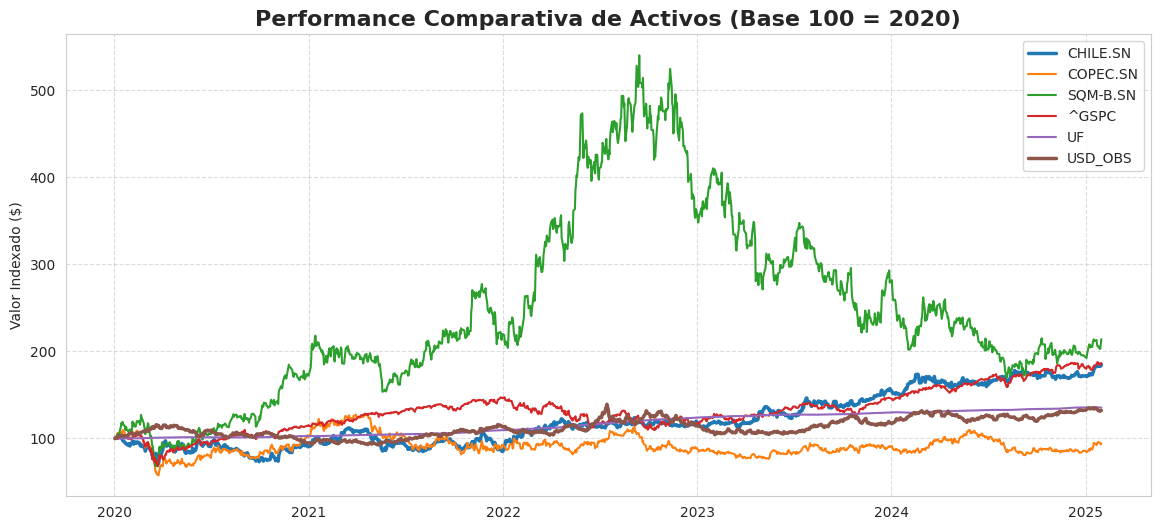

In [26]:
plt.figure(figsize=(14, 6))

# Normalización: Precio_t / Precio_inicial * 100
normalized_prices = (df_master / df_master.iloc[0]) * 100

for column in normalized_prices.columns:
    # Destacamos Chile y Dólar con grosor, el resto normal
    linewidth = 2.5 if 'CHILE' in column or 'USD' in column else 1.5
    plt.plot(normalized_prices.index, normalized_prices[column], label=column, linewidth=linewidth)

plt.title("Performance Comparativa de Activos (Base 100 = 2020)", fontsize=16, fontweight='bold')
plt.ylabel("Valor Indexado ($)")
plt.legend()
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.show()

### Validación de la Hipótesis Distribucional (SDE Compliance)

**Fundamento Teórico:**
De acuerdo con la **Sección 2.1** de las *Especificaciones Matemáticas de CL-RiskEngine*, la dinámica de precios se modela mediante la Ecuación Diferencial Estocástica (SDE) del Movimiento Browniano Geométrico:

Donde el término difusivo  representa un incremento de Wiener estándar. Para que esta aproximación sea válida en la simulación, los **retornos logarítmicos**  deben converger a una distribución Normal .

**Objetivo del Diagnóstico:**
Evaluaremos la **Bondad de Ajuste (Goodness-of-Fit)** de la distribución empírica de los retornos frente a la PDF (Función de Densidad de Probabilidad) Gaussiana teórica.

* **Ajuste Central:** Valida el comportamiento promedio ().
* **Análisis de Colas:** Detecta *Leptocurtosis* ("Colas Gordas"), lo cual evidenciaría que el modelo GBM podría subestimar riesgos extremos (Black Swans), una limitación que debe ser documentada.

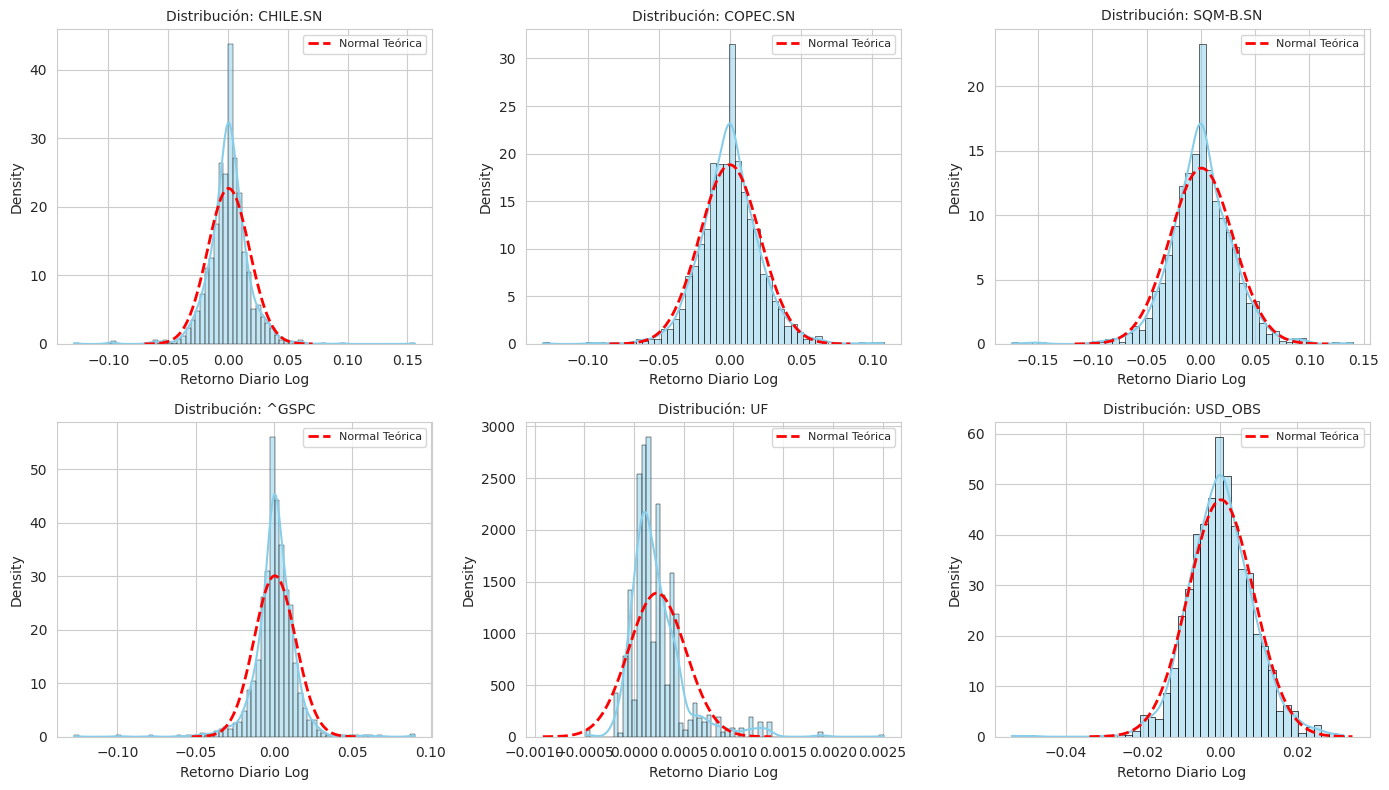

✅ Visualización completada.


In [27]:
plt.figure(figsize=(14, 8))
activos_a_analizar = df_returns.columns # Todos los de la capa Silver

for i, activo in enumerate(activos_a_analizar, 1):
    plt.subplot(2, 3, i) # Ajusta grid según cantidad de activos (2 filas, 3 columnas)
    
    # Histograma + KDE (Curva de densidad estimada)
    sns.histplot(df_returns[activo], kde=True, stat="density", color="skyblue", edgecolor="black")
    
    # Curva Normal Teórica (Referencia)
    mu, std = df_returns[activo].mean(), df_returns[activo].std()
    x = np.linspace(mu - 4*std, mu + 4*std, 100)
    p = stats.norm.pdf(x, mu, std)
    plt.plot(x, p, 'r--', linewidth=2, label='Normal Teórica')
    
    plt.title(f"Distribución: {activo}", fontsize=10)
    plt.xlabel("Retorno Diario Log")
    plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

print("✅ Visualización completada.")